# IVF Study #

In [2]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
load_dotenv()
import urllib.request
url = "http://purl.obolibrary.org/obo/go/go-basic.obo"
urllib.request.urlretrieve(url, "go-basic.obo")
from goatools.obo_parser import GODag
go_dag = GODag("go-basic.obo", optional_attrs=['definition'])

go-basic.obo: fmt(1.2) rel(2025-07-22) 43,230 Terms


### Connect to the SQL database. ###

In [4]:
# PostgreSQL connection details
host = "localhost"
dbname = "IVF"
user = "postgres"
password = os.getenv("PASSWORD")

# Create an SQLAlchemy engine
engine = create_engine(f"postgresql://{user}:{password}@{host}/{dbname}")

### We begin with a data summary. ###

In [6]:
# Initialize the summary data structure
summary_df = pd.DataFrame(columns=[
    'patient_id',

    # 2a: Variant Burden & Frequency
    'count_baseline_variants',
    'count_somatic_variants',
    'mean_af_baseline',
    'mean_af_somatic',
    'count_af_over_20_baseline',
    'count_af_over_20_somatic',
    'shared_loci_count',

    # 2b: Functional Impact
    'pathogenic_clinvar_count',
    'high_impact_function_count',
    'damaging_sift_count',
    'damaging_polyphen_count',
    'mean_phred_qual_score',

    # 2c: Gene & Pathway Features
    'ivf_gene_variant_count',
    'reproductive_go_variant_count',
    'unique_genes_affected'
])

In [7]:
patient_ids = [1, 2, 3, 4, 5, 6]
results = []

for pid in patient_ids:
    
    # Count Variants
    count_baseline_query = f""" 
        SELECT COUNT(*) AS count 
        FROM all_baseline 
        WHERE patient_id = {pid} 
    """
    count_baseline = pd.read_sql(count_baseline_query, engine).iloc[0]['count']
    
    count_somatic_query = f""" 
        SELECT COUNT(*) AS count 
        FROM all_somatic 
        WHERE patient_id = {pid} 
    """
    count_somatic = pd.read_sql(count_somatic_query, engine).iloc[0]['count']

    # Allele frequency
    allele_freq_baseline_query = f""" 
        SELECT allele_frequency_percent 
        FROM all_baseline 
        WHERE patient_id = {pid} 
    """
    allele_freq_baseline_df = pd.read_sql(allele_freq_baseline_query, engine)
    allele_freq_baseline_df['source'] = 'baseline'

    allele_freq_somatic_query = f""" 
        SELECT allele_frequency_percent 
        FROM all_somatic 
        WHERE patient_id = {pid} 
    """
    allele_freq_somatic_df = pd.read_sql(allele_freq_somatic_query, engine)
    allele_freq_somatic_df['source'] = 'somatic'
    
    # Combine into one DataFrame
    allele_freq_df = pd.concat([allele_freq_baseline_df, allele_freq_somatic_df], ignore_index=True)
    allele_freq_df['allele_frequency_percent'] = pd.to_numeric(allele_freq_df['allele_frequency_percent'], errors='coerce')

    # Compute the mean allele frequencies
    mean_af_source = allele_freq_df.groupby('source')['allele_frequency_percent'].mean()
    mean_af_baseline = mean_af_source.get('baseline', float('nan'))
    mean_af_somatic = mean_af_source.get('somatic', float('nan'))

    # Counts over threshold
    allele_freq_df['af_gt_20'] = allele_freq_df['allele_frequency_percent'] > 20
    count_af_over_20_source = allele_freq_df.groupby('source')['af_gt_20'].sum()
    count_af_over_20_baseline = count_af_over_20_source.get('baseline', float('nan'))
    count_af_over_20_somatic = count_af_over_20_source.get('somatic', float('nan'))

    # Shared loci count
    baseline_loci_query = f"""
        SELECT DISTINCT locus
        FROM all_baseline
        WHERE patient_id = {pid}
    """
    baseline_loci_df = pd.read_sql(baseline_loci_query, engine)
    baseline_loci = set(baseline_loci_df['locus'])

    somatic_loci_query = f"""
        SELECT DISTINCT locus
        FROM all_somatic
        WHERE patient_id = {pid}
    """
    somatic_loci_df = pd.read_sql(somatic_loci_query, engine)
    somatic_loci = set(somatic_loci_df['locus'])

    # Find shared loci
    shared_loci = baseline_loci.intersection(somatic_loci)
    shared_loci_count = len(shared_loci)

    # Pathogenic count  
    clinvar_baseline_query = f""" 
        SELECT clinvar 
        FROM all_baseline 
        WHERE patient_id = {pid}
    """
    clinvar_baseline_df = pd.read_sql(clinvar_baseline_query, engine)
    clinvar_baseline_df['source'] = 'baseline'
    clinvar_somatic_query = f""" 
        SELECT clinvar 
        FROM all_somatic 
        WHERE patient_id = {pid}
    """
    clinvar_somatic_df = pd.read_sql(clinvar_somatic_query, engine)
    clinvar_somatic_df['source'] = 'somatic'
    clinvar_df = pd.concat([clinvar_baseline_df, clinvar_somatic_df], ignore_index=True)
    pathogenic_count = clinvar_df[clinvar_df['clinvar'].str.contains('pathogenic', case=False, na=False)]['clinvar'].count()

    # High impact function count
    high_impact_terms = ['frameshift', 'stop_gained', 'splice_donor', 'splice_acceptor']
    function_baseline_query = f""" 
        SELECT function 
        FROM all_baseline 
        WHERE patient_id = {pid}
    """
    function_baseline_df = pd.read_sql(function_baseline_query, engine)
    function_baseline_df['source'] = 'baseline'
    function_somatic_query = f""" 
        SELECT function 
        FROM all_somatic 
        WHERE patient_id = {pid}
    """
    function_somatic_df = pd.read_sql(function_somatic_query, engine)
    function_somatic_df['source'] = 'somatic'
    function_df = pd.concat([function_baseline_df, function_somatic_df], ignore_index=True)
    high_impact_function_count = function_df[function_df['function'].str.contains('|'.join(high_impact_terms), case=False, na=False)]['function'].count()

    # Damaging sift count
    sift_baseline_query = f""" 
        SELECT sift 
        FROM all_baseline 
        WHERE patient_id = {pid}
    """
    sift_baseline_df = pd.read_sql(sift_baseline_query, engine)
    sift_baseline_df['source'] = 'baseline'
    sift_somatic_query = f""" 
        SELECT sift 
        FROM all_somatic 
        WHERE patient_id = {pid}
    """
    sift_somatic_df = pd.read_sql(sift_somatic_query, engine)
    sift_somatic_df['source'] = 'somatic'
    sift_df = pd.concat([sift_baseline_df, sift_somatic_df], ignore_index=True)
    sift_df['sift'] = pd.to_numeric(sift_df['sift'], errors='coerce')
    damaging_sift_count = sift_df[sift_df['sift'] < 0.05]['sift'].count()

    # Damaging polyphen count
    polyphen_baseline_query = f""" 
        SELECT polyphen 
        FROM all_baseline 
        WHERE patient_id = {pid}
    """
    polyphen_baseline_df = pd.read_sql(polyphen_baseline_query, engine)
    polyphen_baseline_df['source'] = 'baseline'
    polyphen_somatic_query = f""" 
        SELECT polyphen 
        FROM all_somatic 
        WHERE patient_id = {pid}
    """
    polyphen_somatic_df = pd.read_sql(polyphen_somatic_query, engine)
    polyphen_somatic_df['source'] = 'somatic'
    polyphen_df = pd.concat([polyphen_baseline_df, polyphen_somatic_df], ignore_index=True)
    polyphen_df['polyphen'] = pd.to_numeric(polyphen_df['polyphen'], errors='coerce')
    damaging_polyphen_count = polyphen_df[polyphen_df['polyphen'] > 0.85]['polyphen'].count()

    # Mean phred qual score
    phred_qual_score_baseline_query = f""" 
        SELECT phred_qual_score 
        FROM all_baseline 
        WHERE patient_id = {pid}
    """
    phred_qual_score_baseline_df = pd.read_sql(phred_qual_score_baseline_query, engine)
    phred_qual_score_baseline_df['source'] = 'baseline'
    phred_qual_score_somatic_query = f""" 
        SELECT phred_qual_score 
        FROM all_somatic 
        WHERE patient_id = {pid}
    """
    phred_qual_score_somatic_df = pd.read_sql(phred_qual_score_somatic_query, engine)
    phred_qual_score_somatic_df['source'] = 'somatic'
    phred_qual_score_df = pd.concat([phred_qual_score_baseline_df, phred_qual_score_somatic_df], ignore_index=True)
    phred_qual_score_df['phred_qual_score'] = pd.to_numeric(phred_qual_score_df['phred_qual_score'], errors='coerce')
    mean_phred_qual_score = phred_qual_score_df['phred_qual_score'].mean()

    # IVF gene variant count
    ivf_genes = ['BRCA1', 'BRCA2', 'FMR1', 'NR5A1', 'ESR1', 'FSHR', 'LHCGR', 'AMH', 'BMP15', 'GDF9', 'ZP3', 'ZP1', 'ZP2', 'NANOS3', 'NOBOX', 'FIGLA']
    gene_baseline_query = f""" 
        SELECT gene
        FROM all_baseline 
        WHERE patient_id = {pid}
    """
    gene_baseline_df = pd.read_sql(gene_baseline_query, engine)
    gene_baseline_df['source'] = 'baseline'
    gene_somatic_query = f""" 
        SELECT gene 
        FROM all_somatic 
        WHERE patient_id = {pid}
    """
    gene_somatic_df = pd.read_sql(gene_somatic_query, engine)
    gene_somatic_df['source'] = 'somatic'
    gene_df = pd.concat([gene_baseline_df, gene_somatic_df], ignore_index=True)
    ivf_gene_variant_count = gene_df[gene_df['gene'].isin(ivf_genes)]['gene'].count()
    unique_genes_affected = gene_df['gene'].nunique()
    
    # Reproductive go variant count
    repro_terms = ['reproduction', 'fertilization', 'oogenesis', 'spermatogenesis', 'embryo','gonad', 'infertility', 'implantation', 'oocyte', 'sperm', 'zygote','follicle', 'blastocyst', 'luteinizing', 'FSH', 'hormone', 'gonadotropin']
    repro_go_ids = set()
    for go_id, term in go_dag.items():
        name = term.name.lower()
        definition = getattr(term, 'definition', getattr(term, 'defn', '')).lower()
        if any(r in name or r in definition for r in repro_terms):
            repro_go_ids.add(go_id)
    go_baseline_query = f""" 
        SELECT go
        FROM all_baseline 
        WHERE patient_id = {pid}
    """
    go_baseline_df = pd.read_sql(go_baseline_query, engine)
    go_baseline_df['source'] = 'baseline'
    go_somatic_query = f""" 
        SELECT go 
        FROM all_somatic 
        WHERE patient_id = {pid}
    """
    go_somatic_df = pd.read_sql(go_somatic_query, engine)
    go_somatic_df['source'] = 'somatic'
    go_df = pd.concat([go_baseline_df, go_somatic_df], ignore_index=True)
    reproductive_go_variant_count = go_df[go_df['go'].str.contains('|'.join(repro_go_ids), case=False, na=False)]['go'].count()

    # Append results
    results.append({
        'patient_id': pid,
        'count_baseline_variants': count_baseline,
        'count_somatic_variants': count_somatic,
        'mean_af_baseline': mean_af_baseline,
        'mean_af_somatic': mean_af_somatic,
        'count_af_over_20_baseline': count_af_over_20_baseline,
        'count_af_over_20_somatic': count_af_over_20_somatic,
        'shared_loci_count': shared_loci_count,
        'pathogenic_clinvar_count': pathogenic_count,
        'high_impact_function_count': high_impact_function_count,
        'damaging_sift_count': damaging_sift_count,
        'damaging_polyphen_count': damaging_polyphen_count,
        'mean_phred_qual_score': mean_phred_qual_score,
        'ivf_gene_variant_count': ivf_gene_variant_count,
        'reproductive_go_variant_count': reproductive_go_variant_count,
        'unique_genes_affected': unique_genes_affected
    })

# Create summary DataFrame
summary_df = pd.DataFrame(results)
print(summary_df)


   patient_id  count_baseline_variants  count_somatic_variants  \
0           1                    50263                   46330   
1           2                    52099                   53132   
2           3                    52125                   55451   
3           4                    49572                   43913   
4           5                    52394                   52362   
5           6                    52936                   59137   

   mean_af_baseline  mean_af_somatic  count_af_over_20_baseline  \
0         68.780500        65.120089                      49373   
1         68.501330        65.704918                      51044   
2         68.314328        63.766697                      51155   
3         69.471021        65.754442                      48774   
4         68.789142        66.012886                      51353   
5         68.227191        63.898222                      51653   

   count_af_over_20_somatic  shared_loci_count  pathogenic_clinvar_

In [8]:
sift_df.head()

,sift,source
0,NaN,baseline
1,NaN,baseline
2,NaN,baseline
3,NaN,baseline
4,NaN,baseline


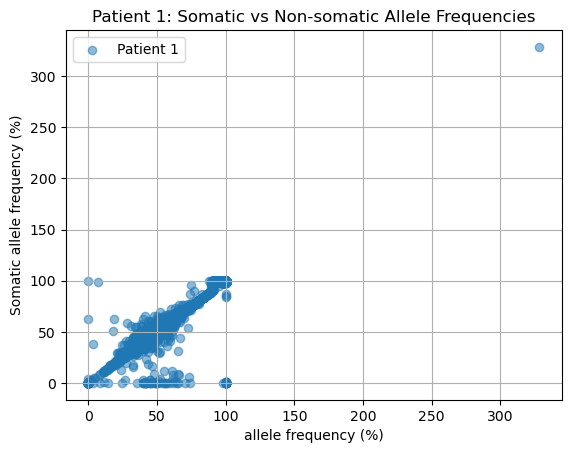

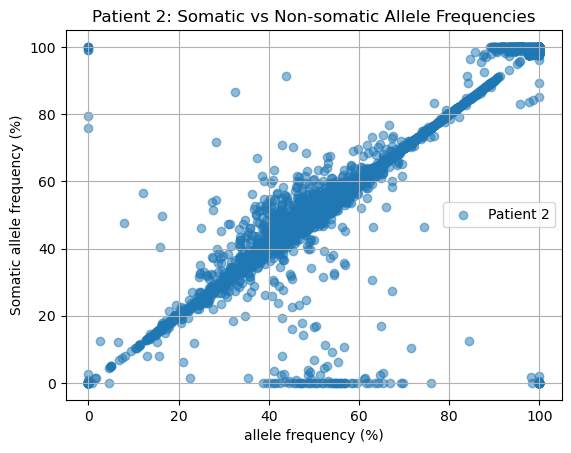

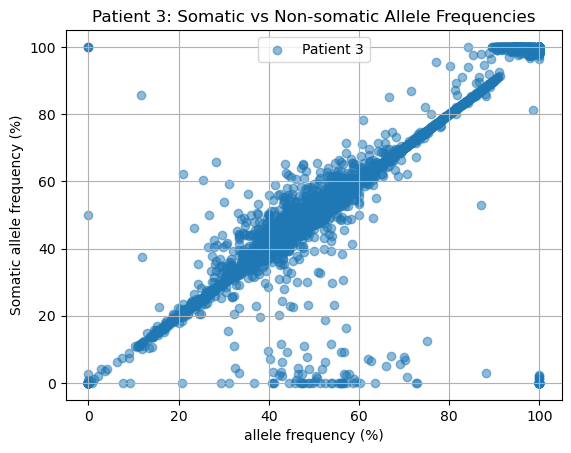

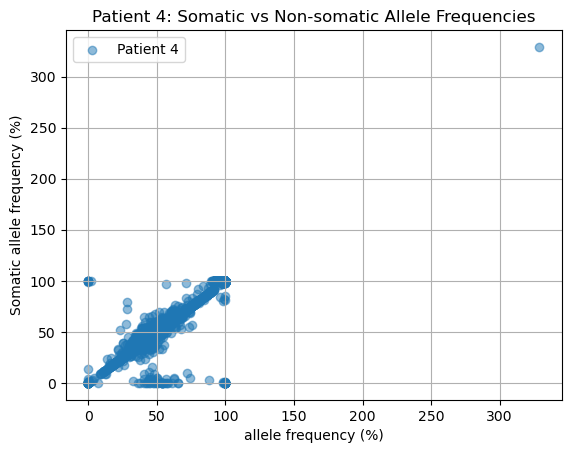

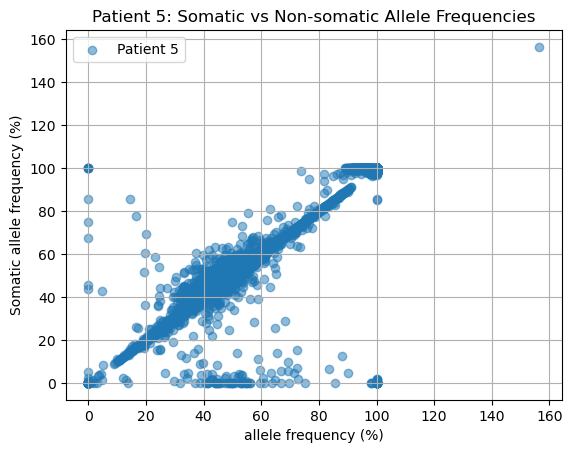

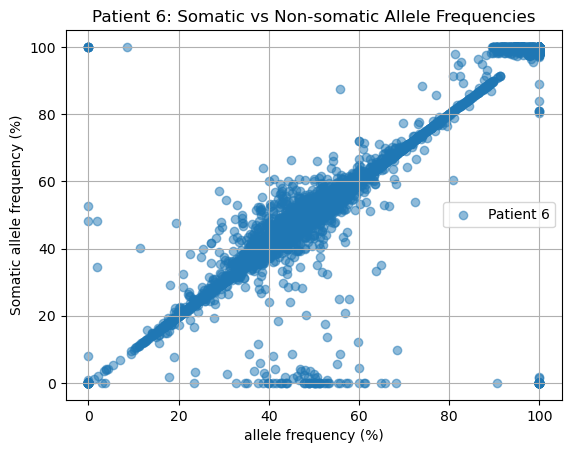

In [9]:
# Query to get allele frequency for both somatic and non-somatic data
query = """
    SELECT patient, allele_frequency, somatic_allele_frequency 
    FROM allele_frequency_updated
    WHERE allele_frequency IS NOT NULL AND somatic_allele_frequency IS NOT NULL;
"""

# Read data into a pandas DataFrame
df = pd.read_sql(query, engine)

# Group data by patient
patients = df['patient'].unique()

# Plot for each patient
for patient in patients:
    patient_data = df[df['patient'] == patient]
    
    # Scatter plot for somatic vs non-somatic allele frequency
    plt.scatter(patient_data['allele_frequency'], patient_data['somatic_allele_frequency'], 
                label=f'Patient {patient}', alpha=0.5)
    plt.xlabel('allele frequency (%)')
    plt.ylabel('Somatic allele frequency (%)')
    plt.title(f'Patient {patient}: Somatic vs Non-somatic Allele Frequencies')
    plt.legend()
    plt.grid(True)
    plt.show()

# Optional: Combine all patients into a single plot
# plt.scatter(df['non_somatic_allele_freq'], df['somatic_allele_frequency_percent'], alpha=0.5)
# plt.xlabel('Non-somatic allele frequency (%)')
# plt.ylabel('Somatic allele frequency (%)')
# plt.title('Somatic vs Non-somatic Allele Frequencies (All Patients)')
# plt.grid(True)
# plt.show()
